# Reliability model revetments (Port of Merak as case study)

In [7]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("default")

### Input parameters (i.r.t LAT)

In [8]:
N = 10000 #Number of runs Monte Carlo analysis
zeros = np.zeros(N)


#Mean value hydraulic loads
SLR_mean = 0.0
Hwaves_mean = 1.28 


#Min and max values for the different loads
SLR_max = 2 # m
SLR_min = 0 # m

Hwaves_max = 3 # m
Hwaves_min = 0.5 # m

#waterlevels
DWL_mean = 2 + SLR_mean # m
HAT_mean = 1 # m
MSL_mean = 0.53 # m
hcrest_mean = 4.1 # m

#other parameters
alpha_mean = 1/2 # -
Tm1_mean = 3.7 # s
gammab_mean = 1 # -
gammaf_mean = 0.55 # -
gammaBeta_mean = 1 # -
gammav_mean = 1 # -

g_mean = 9.81 # m/s^2
Dn50_mean = 0.5 # m
Delta_mean = 1.54 # - 
Nod_mean = 4.0 # - 
P_mean = 0.1 # - 
Sd_mean = 4.0 # - 
N_mean = 3000 # - 
Cpl_mean = 6.2 # - 
Cs_mean = 1.0 # - 

#resistance terms limit state functions
overtopping_R = 5 # l/s/m
toe_R = Nod_mean # 
erosion_R = 0.5 # m
vanderMeer_R = 0.5 # m

### probabilistic distributions input parameters

In [4]:
#Overflow
hcrest = scipy.stats.norm(hcrest_mean, 0.05*hcrest_mean).rvs(N)
DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
HAT = scipy.stats.norm(HAT_mean, 0.05*HAT_mean).rvs(N)

#Overtopping
g = scipy.stats.norm(g_mean, 0.0).rvs(N)
alpha = scipy.stats.norm(alpha_mean, 0.05*alpha_mean).rvs(N)
Tm1 = scipy.stats.norm(Tm1_mean, 0.05*Tm1_mean).rvs(N)
gammab = scipy.stats.norm(gammab_mean, 0.0*gammab_mean).rvs(N)
gammaf = scipy.stats.norm(gammaf_mean, 0.0*gammaf_mean).rvs(N)
gammaBeta = scipy.stats.norm(gammaBeta_mean, 0.0*gammaBeta_mean).rvs(N)
gammav = scipy.stats.norm(gammav_mean, 0.0*gammav_mean).rvs(N)
overtopping = scipy.stats.norm(overtopping_R,0.05*overtopping_R).rvs(N)

#vanderMeer
Delta = scipy.stats.norm(Delta_mean, 0.05*Delta_mean).rvs(N)
Dn50 = scipy.stats.norm(Dn50_mean, 0.05*Dn50_mean).rvs(N)
Nwaves = scipy.stats.norm(N_mean, 0.05*N_mean).rvs(N)
P = scipy.stats.norm(P_mean, 0.05*P_mean).rvs(N)
Cpl = scipy.stats.norm(Cpl_mean,0.4).rvs(N)
Cs = scipy.stats.norm(Cs_mean, 0.08).rvs(N)
vanderMeer = scipy.stats.norm(vanderMeer_R, 0.05*vanderMeer_R).rvs(N)

#Toearmour & erosion
Sd = scipy.stats.norm(Sd_mean, 0*Sd_mean).rvs(N)
toearmour = scipy.stats.lognorm(toe_R, 0.15*toe_R).rvs(N)
erosion = scipy.stats.lognorm(erosion_R, 0.15*erosion_R).rvs(N)

### Limit state functions

In [5]:
def Overflow( SLR_mean , Hwaves_mean , hcrest, DWL):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    R_overflow = hcrest
    S_overflow = DWL + SLR +0.2*Hwaves
    LS_overflow = R_overflow - S_overflow
    return LS_overflow

def Overtopping(overtopping,g,hcrest, Tm1, alpha, gammab, SLR_mean, Hwaves_mean, gammaf, gammaBeta, gammav):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    Rc = hcrest - DWL - SLR 
    Lm1 = (g*Tm1**2) / (2*np.pi)
    Irri = (alpha)/((Hwaves/Lm1)**0.5)
    
    if any(Rc) > 0.0 and all(Irri) < 7:
        S_overtopping = (((g*Hwaves**3)**0.5)*(0.023/((alpha)**0.5))*gammab*Irri*np.exp(-(2.7*np.abs(Rc/(Irri*Hwaves*gammab*gammaf*gammaBeta*gammav))))**1.3)*1000
        S_overtopping_max = (((g*Hwaves**3)**0.5)*0.09*np.exp(-(1.5*abs(Rc)/(Hwaves*gammaf*gammaBeta*gammav))**1.3))*1000
        #if np.nanmean(S_overtopping) >= np.nanmean(S_overtopping_max):
            #S_overtopping = S_overtopping_max
    elif any(Rc) > 0.0 and all(Irri) > 7:
        S_overtopping = (((g*Hwaves**3)**0.5)*(1/(10**0.79))*np.exp(-Rc/((Hwaves*gammab*gammaf)*(0.33+0.022*Irri)))**1.3)*1000
    else:
        S_overtopping = overtopping+1
        
    # ensuring only real nubers are accounted for
    S_overtopping = np.array(S_overtopping)
    count_nan = N - np.count_nonzero(~np.isnan(S_overtopping))
    if count_nan > 0.001*N:
        S_overtopping = overtopping+1
    R_overtopping = overtopping
    LS_overtopping = R_overtopping - S_overtopping 
    return LS_overtopping

def VanderMeer(g, SLR_mean, Hwaves_mean, Cpl,Cs, vanderMeer ,P , DWL , Sd , Nwaves):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    Lm1 = (g*Tm1**2) / (2*np.pi)
    Irri = (alpha)/((Hwaves/Lm1)**0.5)
    xi = ((Cpl/Cs)*P**0.31*((alpha)**0.5))**(1/(P+0.5))
    if np.nanmean(Irri) < np.nanmean(xi):
        S_Meer = Hwaves/(Delta*Cpl*(P**0.18)*(1/(np.sqrt(Irri)))*((Sd/np.sqrt(abs(Nwaves)))**0.2))
    elif np.nanmean(Irri) > np.nanmean(xi):
        S_Meer = Hwaves/(Delta*Cs*(1/(P**0.13))*(Irri**P)*((Sd/(np.sqrt(abs(Nwaves))**0.5))**0.2)*(1/alpha)**0.5)
    R_Meer = vanderMeer
    LS_Meer = R_Meer - S_Meer
    return LS_Meer

def Toe_armour( SLR_mean, Hwaves_mean, DWL_mean ,toearmour,HAT ,Dn50, Delta):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
    htoe = DWL- HAT + SLR
    if np.nanmean(htoe)/np.nanmean(Hwaves) < 2:
        S_toe = (Hwaves/((((0.24*(htoe/Dn50)+1.6))*Delta*Dn50)))**(1/0.15)
        R_toe = toearmour
        LS_toe = R_toe - S_toe 
    else:
        LS_toe = 1
    return LS_toe

def Erosion( SLR_mean, Hwaves_mean, erosion, alpha, DWL_mean,Tm1,g):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
    Lm1 = (g*Tm1**2) / (2*np.pi)
    angle = np.arctan(alpha)*(360/(2*np.pi))
    #angle of incoming waves assumed to be constant 90
    angle = 90 * alpha 
    f = 0.3 - 1.77*np.exp(-angle/15)
    S_erosion = (Hwaves*f) / ((np.sinh((2*np.pi*(DWL+SLR))/Lm1))**1.35)
    R_erosion= erosion
    LS_erosion = R_erosion - S_erosion
    return LS_erosion

#number of failures (LS < 0)
N_overflow = np.less_equal(Overflow(SLR_mean , Hwaves_mean , hcrest, DWL), zeros)
N_overtopping = np.less_equal(Overtopping(overtopping,g,hcrest, Tm1, alpha, gammab, SLR_mean, Hwaves_mean, gammaf, gammaBeta, gammav), zeros)
N_vanderMeer = np.less_equal(VanderMeer(g, SLR_mean, Hwaves_mean, Cpl,Cs, vanderMeer ,P , DWL , Sd , Nwaves), zeros)
N_toearmour = np.less_equal(Toe_armour( SLR_mean, Hwaves_mean, DWL_mean ,toearmour,HAT ,Dn50, Delta), zeros)
N_erosion = np.less_equal(Erosion( SLR_mean, Hwaves_mean, erosion, alpha, DWL_mean,Tm1,g),zeros)

#Failure probability (number of failure / total runs)
failure_overflow = np.sum(N_overflow) / float(N)
failure_overtopping = np.sum(N_overtopping) / float(N)
failure_toearmour = np.sum(N_toearmour) / float(N)
failure_Meer = np.sum(N_vanderMeer) / float(N)
failure_erosion = np.sum(N_erosion) / float(N)


#Failure tree (assuming indepedence)
Pf_layer1 = 1-((1-failure_toearmour)*(1-failure_Meer)) #Failure tree armour breakage (OR gates)
Pf_independent = 1-((1-failure_overflow)*(1-failure_overtopping)*(1-Pf_layer1)*(1-failure_erosion)) #Failure top event 
pd.set_option('display.float_format', lambda x: '%.5f' % x)
d = { 'Failure mechanism': ['overflow', 'overtopping', 'toe armour', 'vanderMeer', 'Erosion','Breakwater (independent)'], 
     'Pf': [failure_overflow, failure_overtopping, failure_toearmour, failure_Meer,failure_erosion, Pf_independent]}
df = pd.DataFrame(data=d)
df

,Failure mechanism,Pf
0,overflow,0.00000
1,overtopping,0.06560
2,toe armour,0.01030
3,vanderMeer,0.43390
4,Erosion,0.05810
5,Breakwater (independent),0.50690


## Monte Carlo analysis loop (fragility curves) 

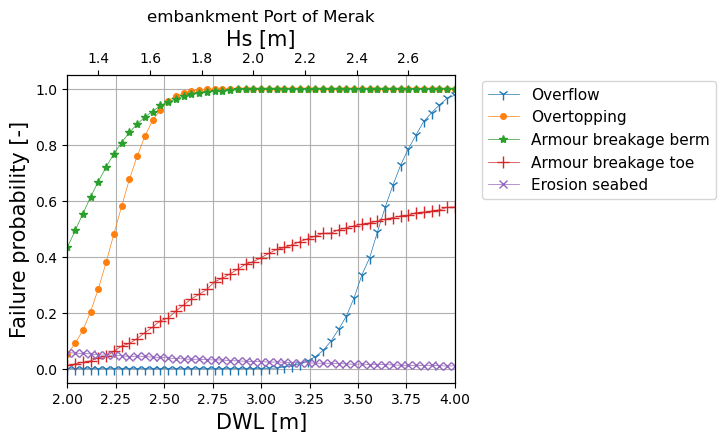

In [6]:
# emplty lists which are filled with conditional failure probabilities when subjected to increased hydraulic loading
list_total = []
list_overtopping = []
list_overflow = []
list_toearmour = []
list_Meer = []
list_erosion = []
list_lower =[]
list_upper =[]


N_vertical = 50 # Number of values on the horizontal axis 


SLR_range =np.arange(SLR_min,1.001*SLR_max ,(SLR_max-SLR_min)/N_vertical)
Hwaves_range = np.arange(Hwaves_min,1.001*Hwaves_max,(Hwaves_max-Hwaves_min)/N_vertical)
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)


#Choose type of hydraulic loading which will gradually increase
# 1 = rising water levels (sea level rise)
# 2 = rising wave height
# 3 = combination of both when incoming waves are depth-limited

x = 3


if x == 1:
    a = SLR_range
    c = scipy.stats.norm(Hwaves_mean, 0.0).rvs(N)
    d = a + DWL_mean
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    title = 'Pf vs DWL' 
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
elif x == 2:
    a = scipy.stats.norm(SLR_mean, 0.0).rvs(N)
    c = Hwaves_range
    d = c 
    ax1.set_xlim(Hwaves_min,  Hwaves_max)
    title = 'Pf vs Hs'
    xas = 'Hs [m]'
    yas = 'Failure probability [-]'
elif x == 3:
    DWL = scipy.stats.norm(DWL_mean, 0.0*DWL_mean).rvs(N)
    a = SLR_range 
    c =  (Hwaves_mean + 0.75*SLR_range)
    d = a + DWL_mean
    title = ''
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
    ax2 = ax1.twiny()
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
    ax2.set_xlabel('Hs [m]', size = 15)



for i in range(len(d)):
    SLR_mean = a[i]
    Hwaves_mean = c[i]
    #list of failures
    failure_overflow = np.sum(np.less_equal(Overflow( SLR_mean , Hwaves_mean , hcrest, DWL), zeros)) / float(N)
    failure_overtopping = np.sum(np.less_equal(Overtopping(overtopping,g,hcrest, Tm1, alpha, gammab, SLR_mean, Hwaves_mean, gammaf, gammaBeta, gammav), zeros)) / float(N)
    failure_toearmour = np.sum(np.less_equal(Toe_armour( SLR_mean, Hwaves_mean, DWL_mean ,toearmour,HAT ,Dn50, Delta), zeros)) / float(N)
    failure_Meer = np.sum(np.less_equal(VanderMeer(g, SLR_mean, Hwaves_mean, Cpl,Cs, vanderMeer ,P , DWL , Sd , Nwaves), zeros)) / float(N)
    failure_erosion = np.sum(np.less_equal(Erosion( SLR_mean, Hwaves_mean, erosion, alpha, DWL_mean,Tm1,g),zeros)) / float(N)
    failure_total = 1-((1-failure_overflow)*(1-failure_overtopping)*(1-failure_toearmour)*(1-failure_Meer)*(1-failure_erosion))
    #list of failures    
    list_toearmour.append(failure_toearmour)
    list_overtopping.append(failure_overtopping)
    list_overflow.append(failure_overflow)
    list_erosion.append(failure_erosion)
    if failure_Meer <1.0:
        list_Meer.append(failure_Meer)
    else:
        list_Meer.append(1.0)
    list_total.append(failure_total)
    
    
#plot total conditional failure probabilities
ax1.plot(d,list_total, label = 'Depth - limiting', linewidth = 0.5, marker ='1', markersize = '8') #plot when using x = 1
#ax1.plot(d,Depth_not, label = ' Not Depth - limiting', linewidth = 0.5, marker ='.', markersize = '8') #plot when using x = 1


#invididual condityiona failure probabilities for failure mechanisms
ax1.plot(d,list_overflow, label ='Overflow',linewidth = 0.5, marker ='1', markersize = '8')
ax1.plot(d,list_overtopping, label = 'Overtopping', linewidth = 0.5, marker ='.', markersize = '8')
ax1.plot(d,list_Meer, label = 'Armour breakage berm', linewidth = 0.5, marker ='*', markersize = '6')
ax1.plot(d,list_toearmour, label ='Armour breakage toe', linewidth = 0.5, marker ='+', markersize = '8')
ax1.plot(d,list_erosion, label ='Erosion seabed', linewidth = 0.5, marker ='x', markersize = '6')

#graph settings
ax1.set_title(title, size = 15)
ax1.grid()
plt.title('embankment Port of Merak')
ax1.set_ylabel(yas, size = 15)
ax1.set_xlabel(xas, size=15)
ax1.legend(bbox_to_anchor=(1.05, 1.005), loc='upper left', ncol = 1,  prop={"size":11})
plt.show()


## FORM ANALYSIS

1.385880467911535
Normal(mu = 2.78, sigma = 0.139)
0.9999669619830257


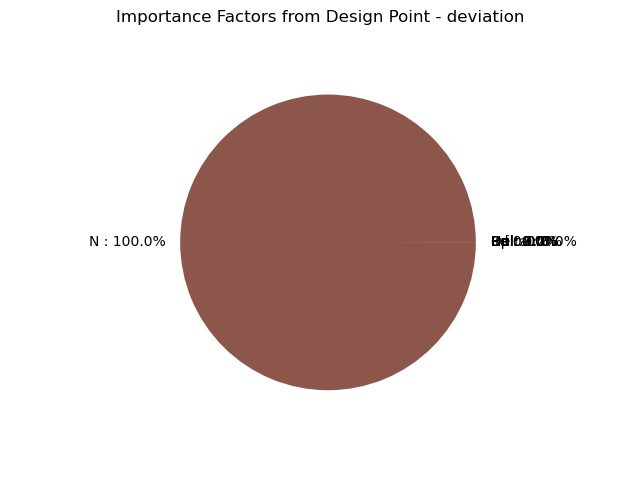

In [6]:
from __future__ import print_function
import openturns as ot

Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
Lm1 = (np.mean(g)*np.mean(Tm1)**2) / (2*np.pi)
Irri = (np.mean(alpha))/((np.mean(Hwaves)/Lm1)**0.5)



dist_Delta = ot.Normal(Delta_mean, 0.05*Delta_mean)
dist_Hs = ot.Normal(Hwaves_mean, 0.05*Hwaves_mean)
print(dist_Hs)
dist_Cpl = ot.Normal(Cpl_mean, 0.4)
dist_P = ot.Normal(P_mean,0.05*P_mean)
dist_Sd = ot.Normal(Sd_mean,0.05*Sd_mean)
dist_N = ot.Normal(N_mean,0.25*N_mean)
dist_Irri = ot.Normal(Irri,0.05*Irri)
marginals = [dist_Delta, dist_Hs, dist_Cpl, dist_P, dist_Sd, dist_N, dist_Irri]

RS = ot.CorrelationMatrix(7)
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R)


distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(['Delta', 'Hs', 'Cpl', 'P', 'Sd', 'N', 'Irri'])
# create the model
model = ot.SymbolicFunction(['Delta', 'Hs', 'Cpl', 'P', 'Sd', 'N', 'Irri'], ['Hs/(Delta*Cpl*(P^0.18)*(Irri^-0.5)*(Sd/(N^0.5))^0.2)'])


vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(model, vect)
event = ot.ThresholdEvent(G, ot.Greater(), 0.48)
event.setName("deviation")
# Define a solver

optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(10000)
optimAlgo.setMaximumAbsoluteError(2.0e-5)
optimAlgo.setMaximumRelativeError(2.0e-5)
optimAlgo.setMaximumResidualError(2.0e-5)
optimAlgo.setMaximumConstraintError(2.0e-5)

# Run FORM
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()
# Probability
print(result.getEventProbability())
# Hasofer reliability index
result.getHasoferReliabilityIndex()

result.getStandardSpaceDesignPoint()


result.getPhysicalSpaceDesignPoint()

# Importance factors
result.drawImportanceFactors()

1.0


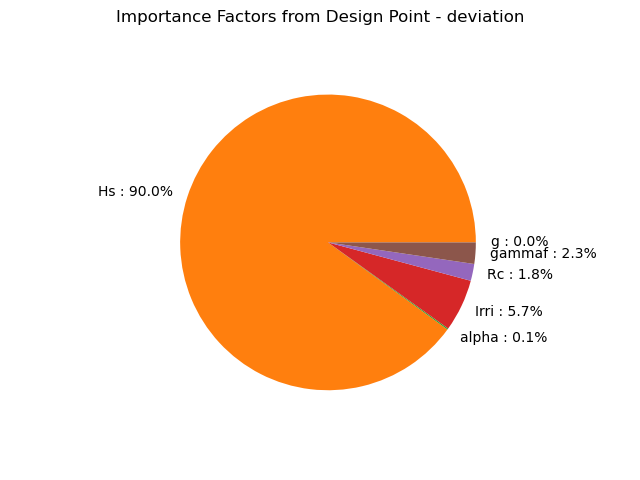

In [8]:
Rc = np.abs(hcrest_mean - DWL_mean - SLR_mean)

Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
Lm1 = (np.mean(g)*np.mean(Tm1)**2) / (2*np.pi)
Irri = (np.mean(alpha))/((np.mean(Hwaves)/Lm1)**0.5)

dist_g = ot.Normal(g_mean, 0.00001*g_mean)
dist_Hs = ot.Normal(Hwaves_mean, 0.05*Hwaves_mean)
dist_alpha = ot.Normal(alpha_mean, 0.05*alpha_mean)
dist_Irri = ot.Normal(Irri,0.05*Irri)
dist_Rc = ot.Normal(Rc, 0.05*Rc)
dist_gammaf = ot.Normal(gammaf_mean,0.05*gammaf_mean)


marginals = [dist_g, dist_Hs, dist_alpha, dist_Irri,dist_Rc, dist_gammaf]

RS = ot.CorrelationMatrix(6)
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R)


distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(['g', 'Hs', 'alpha', 'Irri', 'Rc', 'gammaf'])
# create the model
model = ot.SymbolicFunction(['g', 'Hs', 'alpha', 'Irri', 'Rc', 'gammaf'], ['((g*Hs^3)^0.5)*(0.023/((alpha)^0.5))*Irri*exp(-(2.7*Rc/(Irri*Hs*gammaf))^1.3)'])


vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(model, vect)
event = ot.ThresholdEvent(G, ot.Greater(), 0.005)
event.setName("deviation")
# Define a solver

optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(100000)
optimAlgo.setMaximumAbsoluteError(2.0e-5)
optimAlgo.setMaximumRelativeError(2.0e-5)
optimAlgo.setMaximumResidualError(2.0e-5)
optimAlgo.setMaximumConstraintError(2.0e-5)

# Run FORM
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()
# Probability
print(result.getEventProbability())
# Hasofer reliability index
result.getHasoferReliabilityIndex()

result.getStandardSpaceDesignPoint()


result.getPhysicalSpaceDesignPoint()

# Importance factors
result.drawImportanceFactors()


# Structural adaptations and their efficacy